In [1]:
!pip install opencv-python numpy keras tensorflow matplotlib scipy

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import glob

# Check for GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    print(f"✅ GPU detected: {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("❌ No GPU detected. Running on CPU.")

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 8
EPOCHS = 11
LEARNING_RATE = 0.001
DATASET_PATH = 'dataset_bnw'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU detected: /physical_device:GPU:0


In [3]:
# Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    gray_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)
    bgr_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    return bgr_img / 255.0

In [4]:
# Function to load and preprocess dataset
def load_dataset(dataset_path):
    images, labels = [], []
    angle_folders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
    class_indices = {folder: i for i, folder in enumerate(angle_folders)}
    
    for angle_folder in angle_folders:
        angle_path = os.path.join(dataset_path, angle_folder)
        for image_file in glob.glob(os.path.join(angle_path, '*.*')):
            images.append(preprocess_image(image_file))
            labels.append(class_indices[angle_folder])
    
    return np.array(images), np.array(labels), class_indices

In [5]:
# Load dataset
X, y, class_indices = load_dataset(DATASET_PATH)
print(f"Loaded {len(X)} images across {len(class_indices)} angle classes")
y_one_hot = tf.keras.utils.to_categorical(y, num_classes=len(class_indices))
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

Loaded 2657 images across 15 angle classes


In [6]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             zoom_range=0.1)

datagen.fit(X_train)

In [ ]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_indices), activation='softmax')
])

In [8]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001
)

checkpoint = ModelCheckpoint(
    'text_angle_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [10]:
# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, checkpoint]
)


Epoch 1/11
266/266 [==============================] - 11s 27ms/step - loss: 2.5857 - accuracy: 0.1275 - val_loss: 1.5260 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 2/11
266/266 [==============================] - 6s 24ms/step - loss: 1.4970 - accuracy: 0.4268 - val_loss: 0.5207 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 3/11
266/266 [==============================] - 6s 24ms/step - loss: 0.9916 - accuracy: 0.6235 - val_loss: 0.3451 - val_accuracy: 0.9098 - lr: 0.0010
Epoch 4/11
266/266 [==============================] - 6s 23ms/step - loss: 0.7066 - accuracy: 0.7200 - val_loss: 0.2728 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 5/11
266/266 [==============================] - 6s 24ms/step - loss: 0.6368 - accuracy: 0.7656 - val_loss: 0.1599 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 6/11
266/266 [==============================] - 6s 23ms/step - loss: 0.5026 - accuracy: 0.8146 - val_loss: 0.1380 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 7/11
266/266 [==============================] - 6s 23ms/s

In [11]:
print(f"Validation Accuracy: {max(history.history['val_accuracy']) * 100:.2f}%")
print(f"Accuracy: {max(history.history['accuracy']) * 100:.2f}%")

Validation Accuracy: 99.06%
Accuracy: 88.75%


In [12]:
# Save the final model
model.save('angle_detector_model_bnw.h5')

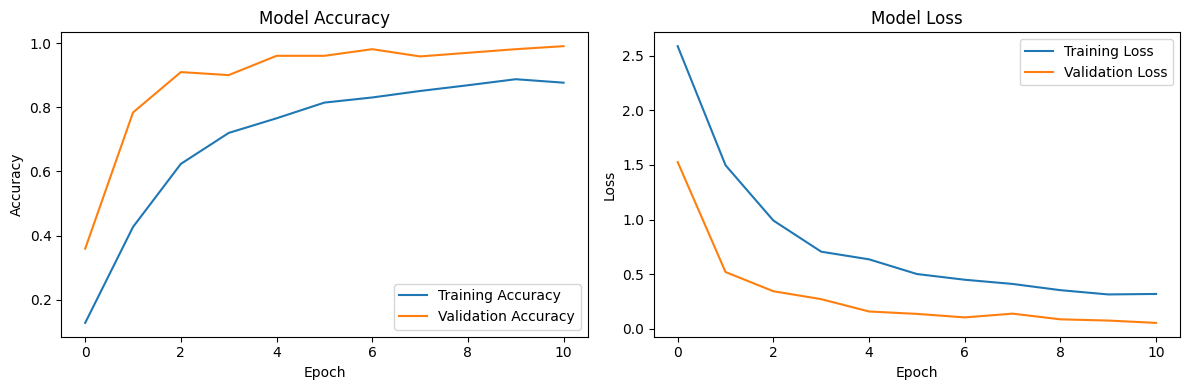

In [13]:
# Plot training results
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Print final learning rate
final_lr = tf.keras.backend.get_value(model.optimizer.lr)

print(f"Final learning rate: {tf.keras.backend.get_value(model.optimizer.lr)} / {final_lr:.1e}")


Final learning rate: 0.0010000000474974513 / 1.0e-03


In [15]:
# Function to predict the angle from an image
def predict_angle(image_path, model, class_indices):
    # Preprocess the image
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
        
    # Make prediction
    prediction = model.predict(img)[0]
    predicted_class = np.argmax(prediction)
    
    # Get the angle from the class index
    reverse_class_mapping = {v: k for k, v in class_indices.items()}
    predicted_angle = reverse_class_mapping[predicted_class]
    
    return predicted_angle, prediction[predicted_class]

In [16]:
test_image_path = 'C:/Users/drflo/Downloads/sample/1.jpg'
predicted_angle, confidence = predict_angle(test_image_path, model, class_indices)
print(f"Predicted angle: {predicted_angle} with confidence: {confidence:.2f}")

1/1 [==============================] - 0s 143ms/step
Predicted angle: 025 with confidence: 0.62
